# Effect of smoothness constraint

In this notebook we plot the components, activations and distance matrix for classic NMF and tsNMF with a large smoothness parameter to demonstrate the effect of adding this smoothness constraint.

In [1]:
import os
import glob
from collections import defaultdict
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import tsnmf

## Load low-rank MVBS data

In [2]:
MVBS_PCP_path = '../data/'
MVBS_rpca_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected_rpca.nc'

In [3]:
MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
low_rank = MVBS_rpca['low_rank']
n_observations, n_frequencies, n_depth_levels, n_pings = low_rank.shape

In [4]:
low_rank = low_rank.values.reshape([n_observations,-1])

In [5]:
low_rank_nonneg = low_rank - low_rank.min()
low_rank_nonneg.shape

(62, 15984)

## tsNMF decomposition

### sm=0 case

In [6]:
# sm=0
model_0 = tsnmf.smoothNMF(n_components=3, 
                        max_iter=2000, 
                        smoothness=0, 
                        sparsity=0, 
                        early_stopping={'type': 'cost'}
                       )
model_0.fit(low_rank_nonneg.T, init='nndsvd')

Stopping at iteration 1964


We normalize the $\mathbf{W}$ components by its norm and multiply the norm to the $\mathbf{H}$ activations.

In [7]:
H_multW_0 = (model_0.H.T*np.linalg.norm(model_0.W, axis=0)).T
W_divW_0 = model_0.W/np.linalg.norm(model_0.W, axis=0)

In [8]:
# check shape
H_multW_0.shape, W_divW_0.shape

((3, 62), (15984, 3))

### sm=5e5 case

From `select_representative_run.ipynb` we selected the tsNMF run with `random_seed=1190`. Here we use this initial condition to perform the decomposition again.

In [9]:
# sm=5e5
model_5e5 = tsnmf.smoothNMF(n_components=3, 
                        max_iter=2000, 
                        smoothness=500000, 
                        sparsity=0, 
                        early_stopping={'type': 'cost'}
                       )
model_5e5.fit(low_rank_nonneg.T, init='random', random_state=1190)

Stopping at iteration 702


We normalize the $\mathbf{W}$ components by its norm and multiply the norm to the $\mathbf{H}$ activations.

In [10]:
H_multW_5e5 = (model_5e5.H.T*np.linalg.norm(model_5e5.W, axis=0)).T
W_divW_5e5 = model_5e5.W/np.linalg.norm(model_5e5.W, axis=0)

In [11]:
# check shape
H_multW_5e5.shape, W_divW_5e5.shape

((3, 62), (15984, 3))

### sm=5e6 case

From `select_representative_run_sm5e6.ipynb` we selected the tsNMF run with `random_seed=2930`. Here we use this initial condition to perform the decomposition again.

In [12]:
# sm=5e6
model_5e6 = tsnmf.smoothNMF(n_components=3, 
                        max_iter=2000, 
                        smoothness=5000000, 
                        sparsity=0, 
                        early_stopping={'type': 'cost'}
                       )
model_5e6.fit(low_rank_nonneg.T, init='random', random_state=2930)

Stopping at iteration 688


We normalize the $\mathbf{W}$ components by its norm and multiply the norm to the $\mathbf{H}$ activations.

In [13]:
H_multW_5e6 = (model_5e6.H.T*np.linalg.norm(model_5e6.W, axis=0)).T
W_divW_5e6 = model_5e6.W/np.linalg.norm(model_5e6.W, axis=0)

In [14]:
# check shape
H_multW_5e6.shape, W_divW_5e6.shape

((3, 62), (15984, 3))

## Match component order

We match the order of component based on the sequence of classic NMF (tsNMF sm=0 case) results.

In [15]:
def match_factors_by_H(Hs, Hs_ref):
    """Order Hs based on Hs_ref.
    """
    rank_num, _ = Hs.shape
    rho = np.corrcoef(Hs_ref, Hs)[:rank_num,rank_num:]
    index = [0 for r in range(rank_num)]
    for p in range(rank_num):
        index_max = np.argmax(rho)
        # index = np.argsort(rho, axis=1)
        i,j = np.unravel_index(index_max,(rank_num,rank_num))
        rho[:,j] = -2
        rho[i,:] = -2
        index[i] = j
    
    return np.array(index).astype(int)

In [16]:
H_seq_5e5 = match_factors_by_H(model_5e5.H, Hs_ref=model_0.H)
H_seq_5e6 = match_factors_by_H(model_5e6.H, Hs_ref=model_0.H)

## Compare activation

In [17]:
# Assemble dataset for activation
ds_activation = xr.Dataset(
    {
        'H_tsNMF_sm0': (['day', 'component'], H_multW_0.T),
        'H_tsNMF_sm5e5': (['day', 'component'], H_multW_5e5[H_seq_5e5, :].T),
        'H_tsNMF_sm5e6': (['day', 'component'], H_multW_5e6[H_seq_5e6, :].T)
    },
    coords={
        'component': np.arange(3),
        'day': MVBS_rpca['low_rank'].date.values
    }
)

In [18]:
panel_ls=12
title_ls=10
freq_ls=8
comp_ls=8
axis_ls=8
legend_ls=6
tick_ls=8
pad_size=1

In [19]:
def plot_activation(axx, H_name):
    h1 = ds_activation[H_name].plot.line(x='day', ax=axx,
                                   add_legend=False, _labels=False)
    axx.xaxis.set_major_locator(
        mdates.MonthLocator(bymonth=range(8,11), bymonthday=[1,15]))
    axx.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    axx.xaxis.set_minor_locator(mdates.AutoDateLocator())
    axx.set_xlim([datetime.date(2015,8,16), datetime.date(2015,10,18)])
    axx.set_title(H_name)
    axx.tick_params(labelsize=tick_ls, pad=pad_size)


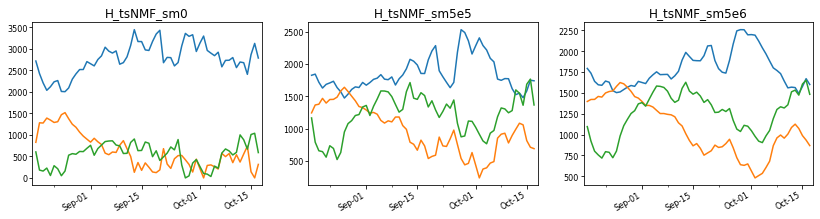

In [20]:
fig,ax = plt.subplots(1, 3, figsize=(14,3))
plot_activation(ax[0], 'H_tsNMF_sm0')
plot_activation(ax[1], 'H_tsNMF_sm5e5')
plot_activation(ax[2], 'H_tsNMF_sm5e6')

## Compare components

In [21]:
W_divW_0_reshaped = W_divW_0.T.reshape(3, n_frequencies*n_depth_levels, n_pings)
W_divW_5e5_reshaped = W_divW_5e5[:, H_seq_5e5].T.reshape(3, n_frequencies*n_depth_levels, n_pings)
W_divW_5e6_reshaped = W_divW_5e6[:, H_seq_5e6].T.reshape(3, n_frequencies*n_depth_levels, n_pings)

In [22]:
# check dimension
W_divW_0_reshaped.shape

(3, 111, 144)

In [23]:
def plot_component(axx, WW, title_str, vlim=None):
    if vlim is None:
        im = axx.imshow(np.hstack(WW), aspect='auto', 
                        cmap='magma', interpolation='none')
    else:
        im = axx.imshow(np.hstack(WW), aspect='auto', 
                        cmap='magma', interpolation='none', vmin=vlim[0], vmax=vlim[1])
    axx.set_title(title_str, fontsize=14)

    pos = axx.get_position()
    cax = fig.add_axes([pos.x0+pos.width+0.01, 
                        pos.y0, 
                        0.01, 
                        pos.y0+pos.height-pos.y0])
    cbar = plt.colorbar(im, cax=cax)

In [24]:
# Find common vmax and vmin
vmax = np.hstack((W_divW_0, W_divW_5e5, W_divW_5e6)).max()
vmin = np.hstack((W_divW_0, W_divW_5e5, W_divW_5e6)).min()

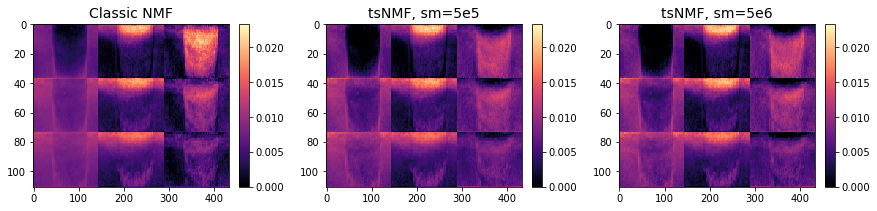

In [25]:
fig,ax = plt.subplots(1, 3, figsize=(14,3))
plt.subplots_adjust(wspace=0.5)
plot_component(ax[0], W_divW_0_reshaped, 'Classic NMF', vlim=[vmin, vmax])
plot_component(ax[1], W_divW_5e5_reshaped, 'tsNMF, sm=5e5', vlim=[vmin, vmax])
plot_component(ax[2], W_divW_5e6_reshaped, 'tsNMF, sm=5e6', vlim=[vmin, vmax])
plt.show()

## Compare distance matrix calculated from activation

In [26]:
from scipy.spatial.distance import pdist, squareform

In [27]:
D_tsNMF_0 = pdist(H_multW_0.T, 'euclidean')
D_tsNMF_5e5 = pdist(H_multW_5e5.T, 'euclidean')
D_tsNMF_5e6 = pdist(H_multW_5e6.T, 'euclidean')

In [28]:
def plot_distance_mtx(axx, DD, title_str):
    im = axx.imshow(squareform(DD), cmap='RdYlBu', interpolation='none')
    axx.set_title(title_str, fontsize=14)

    pos = axx.get_position()
    cax = fig.add_axes([pos.x0+pos.width+0.01, 
                        pos.y0, 
                        0.01, 
                        pos.y0+pos.height-pos.y0])
    plt.ylabel('Euclidean distance', fontsize=14)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.set_ylabel('Euclidean distance', rotation=90, fontsize=12)

In [29]:
D_tsNMF_0.min(), D_tsNMF_5e5.min(), D_tsNMF_5e6.min()

(21.786853783634047, 34.123213701929586, 12.972600411993753)

In [30]:
D_tsNMF_0.max(), D_tsNMF_5e5.max(), D_tsNMF_5e6.max()

(2137.8398437855817, 1685.3482646000434, 1330.4538332993666)

In [31]:
# Normalize the distance to between 0-1
D_tsNMF_0 = (D_tsNMF_0-D_tsNMF_0.min())/(D_tsNMF_0.max()-D_tsNMF_0.min())
D_tsNMF_5e5 = (D_tsNMF_5e5-D_tsNMF_5e5.min())/(D_tsNMF_5e5.max()-D_tsNMF_5e5.min())
D_tsNMF_5e6 = (D_tsNMF_5e6-D_tsNMF_5e6.min())/(D_tsNMF_5e6.max()-D_tsNMF_5e6.min())

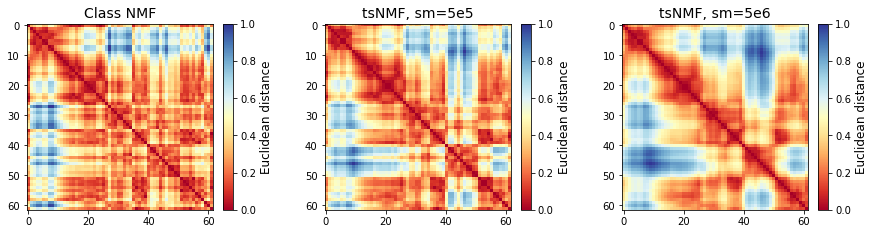

In [32]:
fig,ax = plt.subplots(1, 3, figsize=(14,4))
plt.subplots_adjust(wspace=0.6)
plot_distance_mtx(ax[0], D_tsNMF_0, 'Class NMF')
plot_distance_mtx(ax[1], D_tsNMF_5e5, 'tsNMF, sm=5e5')
plot_distance_mtx(ax[2], D_tsNMF_5e6, 'tsNMF, sm=5e6')
plt.show()

## Fig. SX: putting everything together

In [33]:
import datetime
import matplotlib.dates as mdates
import matplotlib.colors as colors

In [34]:
# Set date locator and formatter to use with plt.plot_dates
date1 = datetime.datetime(2015, 8, 17, 0, 0, 0)
date2 = datetime.datetime(2015, 10, 17, 23, 59, 59)
locator = mdates.AutoDateLocator().get_locator(date1, date2)
formatter = mdates.AutoDateFormatter(locator)
(type(locator), type(formatter))

x_lims = mdates.date2num([date1, date2])
y_lims = mdates.date2num([date1, date2])

In [35]:
# Find common vmax and vmin
W_vmax = np.hstack((W_divW_0, W_divW_5e5, W_divW_5e6)).max()
W_vmin = np.hstack((W_divW_0, W_divW_5e5, W_divW_5e6)).min()

In [36]:
title_size = 14
panel_label_size = 14
tick_label_size = 8
ylabel_size = 8
pad_size = 0

In [37]:
def plot_pattern_sm(gs, WW, vlim):
    axx = []
    for seq in range(3):  # loop through 3 components
        axx.append(fig.add_subplot(gs[0, seq]))
        im = axx[-1].imshow(WW[seq,:,:], aspect='auto',
                            vmax=vlim[1], vmin=vlim[0], cmap='magma', interpolation='none')
    return axx, im

In [38]:
def plot_activation_sm(axx, H_name):
    h1 = ds_activation[H_name].plot.line(x='day', ax=axx,
                                         add_legend=False, _labels=False, lw=1)
    axx.xaxis.set_major_locator(
        mdates.MonthLocator(bymonth=range(8,11), bymonthday=[1,15]))
    axx.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    axx.xaxis.set_minor_locator(mdates.AutoDateLocator())
    axx.set_xlim([datetime.date(2015,8,16), datetime.date(2015,10,18)])
    axx.tick_params(labelsize=tick_ls, pad=pad_size)

In [39]:
def plot_distance_mtx_on_ax(axx, DD, colormap='RdYlBu'):
    im = axx.imshow(squareform(DD), 
                    cmap=colormap, aspect='auto', interpolation='none',
                    extent = [x_lims[0], x_lims[1],  y_lims[1], y_lims[0]])
    axx.xaxis_date()
    axx.xaxis.set_major_locator(
        mdates.MonthLocator(bymonth=range(8,11), bymonthday=[1,15]))
    axx.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    axx.xaxis.set_minor_locator(mdates.AutoDateLocator())
    axx.yaxis_date()
    axx.yaxis.set_major_locator(
        mdates.MonthLocator(bymonth=range(8,11), bymonthday=[1,15]))
    axx.yaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    axx.yaxis.set_minor_locator(mdates.AutoDateLocator())
    plt.setp(axx.get_xticklabels(), rotation=20, 
             fontsize=tick_label_size, horizontalalignment='right')
    plt.setp(axx.get_yticklabels(), rotation=20, 
             fontsize=tick_label_size, horizontalalignment='right')
    axx.tick_params(axis='both', which='major', pad=pad_size)
    axx.tick_params(labelsize=tick_label_size) 
    #     axx.set_aspect('equal', 'box')
    axx.set_xlabel('Time', fontsize=title_ls)
    return im

In [40]:
def plot_daily_echogram_colorbar(im, pos):
    cax = fig.add_axes(pos)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_ticks(np.arange(0,0.035,0.01))
    cbar.ax.tick_params(labelsize=tick_ls, pad=pad_size)
    cbar.ax.set_ylabel('Relative strength\n(normalized)', rotation=90, fontsize=ylabel_size)
    return cbar

In [41]:
def plot_distance_mtx_colorbar(im, pos):
    cax = fig.add_axes(pos)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=tick_ls, pad=pad_size)
    cbar.ax.tick_params(labelsize=tick_label_size) 
    cbar.ax.set_ylabel('Euclidean distance\n(normalized)', rotation=90, fontsize=ylabel_size)
    return cbar

In [42]:
def plot_daily_echogram_pattern_scale(ax_ex):
    ax_ex.set_xticks([])
    ax_ex.set_yticks([])
    ax_ex.set_facecolor(np.ones(3)*0.6)

    trans = ax_ex.transAxes
    # add a line for horizontal scale
    ax_ex.plot([-0.00,1.00],[-0.1,-0.1],
                color='k', lw=1.5, transform=trans, clip_on=False)
    ax_ex.annotate('24 hr', xy=(0.2,-0.5), xycoords=trans, 
                    ha='left', va='bottom', fontsize=axis_ls)
    trans = ax_ex.get_yaxis_transform()
    # add a line for vertical scale
    ax_ex.plot([1.08,1.08],[0.,1], 
                color='k', lw=1.5, transform=trans, clip_on=False)
    ax_ex.annotate('200 m', xy=(1.525,0.6), xycoords=trans, 
                    ha='center', va='top', rotation=0, fontsize=axis_ls)
    fig.text(x=-0.5, y=0.5, s='Scale:', 
             transform=ax_ex.transAxes, fontsize=tick_ls, 
             rotation=0, ha='center', va='center')

In [43]:
def set_ax_ticks(ax):
    """Plot the tick marks for component panels
    """
    ax.set_xticks([])
    ax.set_yticks(np.arange(0,n_depth_levels*3,n_depth_levels)-1)
    ax.set_yticklabels('')
    ax.grid()

In [44]:
def adjust_axis_sizes():
    for axx_pat, axx_act, axx_dist in zip([ax_pattern_sm0, ax_pattern_sm5e5, ax_pattern_sm5e6],
                                          [ax_activation_sm0, ax_activation_sm5e5, ax_activation_sm5e6],
                                          [ax_distance_sm0, ax_distance_sm5e5, ax_distance_sm5e6]):
        pos_pat_L = axx_pat[0].get_position()    # pattern L axis
        pos_pat_R = axx_pat[-1].get_position()   # pattern R axis
        pos_act = axx_act.get_position()      # activation axis
        axx_act.set_position([pos_pat_L.x0,   # left
                              pos_act.y0,     # bottom
                              pos_pat_R.x0+pos_pat_R.width-pos_pat_L.x0,  # width
                              pos_act.height])  # height
        pos_act = axx_act.get_position()        # new activation axis
        pos_dist = axx_dist.get_position()    # distance mtx axis
        axx_dist.set_position([pos_act.x0,      # left
                               pos_dist.y0,     # bottom
                               pos_act.width,   # width
                               pos_act.width+0.036])  # height

In [45]:
# Set custom color cycle
cmap = plt.cm.get_cmap('YlGnBu')

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=cmap([0.3,0.6,1.0]))

In [46]:
def add_daily_echogram_labels():
    for axx_list in [ax_pattern_sm0, ax_pattern_sm5e5, ax_pattern_sm5e6]:
        # move ticks
        [set_ax_ticks(axx) for axx in axx_list]
        # add frequency for echogram patterns
        [fig.text(
                x=-0.35, y=yy, s=ss, transform=axx_list[0].transAxes,
                fontsize=freq_ls,
                ha='center', va='center')
            for ss,yy in zip(['200', '120', '38'], [0.15, 0.5, 0.825])]
        # add component label
        [axx_list[x-1].set_title('#%d' % x, fontsize=tick_ls, pad=3) for x in np.arange(1,4,1)]
    for axx, tstr in zip([ax_pattern_sm0, ax_pattern_sm5e5, ax_pattern_sm5e6], 
                         ['sm=0', 'sm=5e5', 'sm=5e6']):
        fig.text(x=0.5, y=1.2, s=tstr, fontsize=title_ls, 
                 transform=axx[1].transAxes, ha='center', va='center')

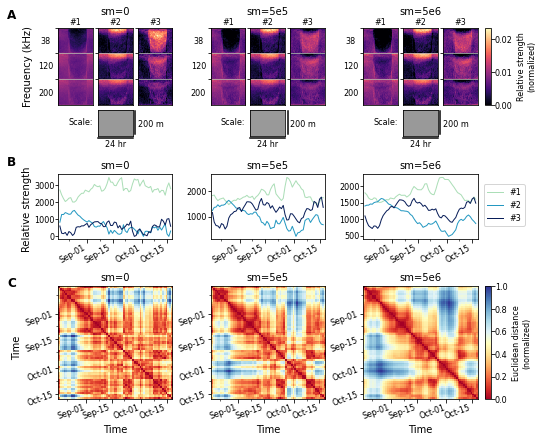

In [47]:
fig = plt.figure(figsize=(7+1/16,6))

gs_top_L = fig.add_gridspec(1,3, bottom=0.82, top=1.0, left=0.05,  right=0.275, wspace=0.15)
gs_top_M = fig.add_gridspec(1,3, bottom=0.82, top=1.0, left=0.35,  right=0.575, wspace=0.15)
gs_top_R = fig.add_gridspec(1,3, bottom=0.82, top=1.0, left=0.65,  right=0.875, wspace=0.15)
gs_mid = fig.add_gridspec(1,3, bottom=0.51, top=0.66, left=0.05,  right=0.875)#, wspace=0.15)
gs_bot = fig.add_gridspec(1,3, bottom=0.14, top=0.54, left=0.05,  right=1)#, wspace=0.15)

# Daily echogram patterns
ax_pattern_sm0, im = plot_pattern_sm(gs_top_L, W_divW_0_reshaped, vlim=[W_vmin, W_vmax])
ax_pattern_sm5e5, _ = plot_pattern_sm(gs_top_M, W_divW_5e5_reshaped, vlim=[W_vmin, W_vmax])
ax_pattern_sm5e6, _ = plot_pattern_sm(gs_top_R, W_divW_5e6_reshaped, vlim=[W_vmin, W_vmax])
pos_ref = ax_pattern_sm5e6[-1].get_position()
pos = [pos_ref.x0+pos_ref.width+0.015, pos_ref.y0, 0.012, pos_ref.height]
plot_daily_echogram_colorbar(im, pos)
add_daily_echogram_labels()
    
# Add echogram panel label
fig.text(x=-0.05,y=1.02,s='A', transform=fig.transFigure,  # position relative to figure
         fontsize=panel_ls, fontweight='bold')
fig.text(x=-0.01, y=0.91, s='Frequency (kHz)', transform=fig.transFigure,  # position relative to figure
         fontsize=title_ls, rotation=90, ha='center', va='center')
 
# Activation
ax_activation_sm0 = fig.add_subplot(gs_mid[0])
plot_activation_sm(ax_activation_sm0, 'H_tsNMF_sm0')
ax_activation_sm5e5 = fig.add_subplot(gs_mid[1])
plot_activation_sm(ax_activation_sm5e5, 'H_tsNMF_sm5e5')
ax_activation_sm5e6 = fig.add_subplot(gs_mid[2])
plot_activation_sm(ax_activation_sm5e6, 'H_tsNMF_sm5e6')
for axx, tstr in zip([ax_activation_sm0, ax_activation_sm5e5, ax_activation_sm5e6], 
                     ['sm=0', 'sm=5e5', 'sm=5e6']):
    axx.set_title(tstr, fontsize=title_ls)
    
# Add activation component legend
ax_activation_sm5e6.legend(['#1', '#2', '#3'], fontsize=tick_ls,
                           bbox_to_anchor=(1.02, 0.15), loc='lower left', ncol=1)
# Add activation panel label
fig.text(x=-0.05,y=0.68,s='B', transform=fig.transFigure, 
         fontsize=panel_ls, fontweight='bold')
fig.text(x=-0.012, y=0.58, s='Relative strength', transform=fig.transFigure,
         fontsize=title_ls, rotation=90, ha='center', va='center')
    
# Distance matrix
ax_distance_sm0 = fig.add_subplot(gs_bot[0])
plot_distance_mtx_on_ax(ax_distance_sm0, D_tsNMF_0, colormap='RdYlBu')
ax_distance_sm5e5 = fig.add_subplot(gs_bot[1])
plot_distance_mtx_on_ax(ax_distance_sm5e5, D_tsNMF_5e5, colormap='RdYlBu')
ax_distance_sm5e6 = fig.add_subplot(gs_bot[2])
im = plot_distance_mtx_on_ax(ax_distance_sm5e6, D_tsNMF_5e6, colormap='RdYlBu')
for axx, tstr in zip([ax_distance_sm0, ax_distance_sm5e5, ax_distance_sm5e6], 
                     ['sm=0', 'sm=5e5', 'sm=5e6']):
    axx.set_title(tstr, fontsize=title_ls)

# Add distance matrix panel label
fig.text(x=-0.05,y=0.4,s='C', transform=fig.transFigure,
         fontsize=panel_ls, fontweight='bold')
fig.text(x=-0.03, y=0.26, s='Time', transform=fig.transFigure,
         fontsize=title_ls, rotation=90, ha='center', va='center')

# Adjust axis sizes
adjust_axis_sizes()

# Plot distance matrix colorbar
pos_ref = ax_pattern_sm5e6[-1].get_position()
pos_curr = ax_distance_sm5e6.get_position()
pos = [pos_ref.x0+pos_ref.width+0.015, pos_curr.y0, 0.012, pos_curr.height]
plot_distance_mtx_colorbar(im, pos)

# Add example axis for daily echogram patterns
gs_top_L = fig.add_gridspec(1,3, bottom=0.82, top=1.0, left=0.05,  right=0.275, wspace=0.15)
gs_top_M = fig.add_gridspec(1,3, bottom=0.82, top=1.0, left=0.35,  right=0.575, wspace=0.15)
gs_top_R = fig.add_gridspec(1,3, bottom=0.82, top=1.0, left=0.65,  right=0.875, wspace=0.15)

for L,R,ax_ref in zip([0.05,  0.35,  0.65],
                      [0.275, 0.575, 0.875], 
                      [ax_pattern_sm0, ax_pattern_sm5e5, ax_pattern_sm5e6]):
    gs_ex = fig.add_gridspec(1,3, bottom=0.75, top=0.85, left=L, right=R)
    ax_ex = fig.add_subplot(gs_ex[1])
    pos_ex = ax_ex.get_position()
    pos_pat_M = ax_ref[1].get_position()   # echogram ref axis
    ax_ex.set_position([pos_pat_M.x0, pos_ex.y0, pos_pat_M.width, pos_pat_M.height/3])
    plot_daily_echogram_pattern_scale(ax_ex)

# Save figure
fig.savefig(os.path.join('../figs', 'fig_si_sm_effects.png'),
            dpi=150, bbox_inches = 'tight', pad_inches = 0.05)

plt.show()